Kiki Chandra & Zoher Ghadyali

Data Science Spring 2016

CYOA Project

## Starting off by using the example from class

The cell below is practically the same as the one we went through in class that uses the tfidf vectorizer to create a matrix where the columns are the individual words used in each post and the rows are each post. We train the model using this matrix, calculate the accuracy of the model in our train-test split, and then use the model to make our predictions on the test data.

In [108]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
import re

%matplotlib inline

train_df = pd.read_table('train.tsv')
test_df = pd.read_table('test.tsv')

vectorizer = TfidfVectorizer()
vectorizer.fit(train_df.Phrase)

X = vectorizer.transform(train_df.Phrase)
y = train_df.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)
print "Accuracy", model.score(X_test, y_test)

model.fit(X, y) #retrain the model using all of the data now before we predict on the test dataset
result = model.predict(vectorizer.transform(test_df.Phrase))
output = pd.DataFrame(data={"PhraseId":test_df["PhraseId"], "Sentiment":result})
output.to_csv( "ZG_rotten_tomatoes_model1.csv", index=False, quoting=3 )

Accuracy 0.622824554658


This csv file got a Kaggle score of 0.6026. We were unable to improve upon this score but we prioritized trying different methods we found from online tutorials and research.

## Using the single words in the train dataset as a lookup table

So pulling from previous iterations of our model, we are going to create a dataframe that contains only the single words from the data. The plot is a histogram that counts how many records in the train data have a certain sentiment and the percentages below that are printed out show what percentage of the train data has that sentiment. We see a lot of 2s (neutral) which makes sense given that these are only the single words and most do not have a lot of connotations by themselves.

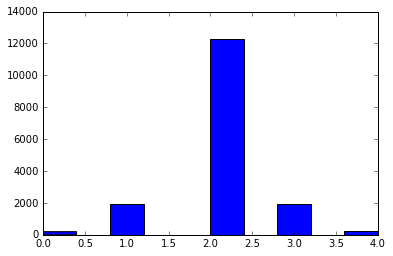

0 0.0119170044159
1 0.115842961708
2 0.742786280322
3 0.116145423749
4 0.0133083298046


In [100]:
import pandas as pd
from matplotlib import pyplot as plt

train_df = pd.read_table('train.tsv')
train_df["containsSpaces"] = train_df["Phrase"].apply(lambda x: ' ' in x)
sw = train_df[train_df.containsSpaces == False]

plt.hist(sw.Sentiment)
plt.show()
for i in range(0, 5):
    print i, len(sw[sw.Sentiment == i]) / float(len(sw))

For this iteration of the model, we decided to use the single words as a lookup table. So instead of training a model and predicting the test data off of that, we use a dictionary of all the single words and their sentiment from the train data and we use it to average the sentiment of each phrase. We then calculate our accuracy within the train data by comparing the calculated sentiment to the actual sentiment.

In [105]:
sw_dict = sw.set_index('Phrase')['Sentiment'].to_dict()

def get_sentiment_single_word(word):
    """ Takes a word in as input, looks for it in the dictionary of single words and their sentiments, and returns the
    sentiment of the word if it is in the dictionary. Otherwise it returns 2 which is neutral"""
    if word in sw_dict:
        return sw_dict[word]
    else:
        return 2

def get_sentiment_phrase(phrase):
    """Takes a phrase as input, creates an empty list of the sentiments for each word in that phrase, and loops
    through the words in the phrase, appending the sentiment of each word to the list. Once we have finished, we
    return the average of the values in the list, or if the list is empty, we return 2"""
    phrase_sentiment = []
    for word in phrase.split():
        phrase_sentiment.append(get_sentiment_single_word(word))
    if len(phrase_sentiment):
        return int(sum(phrase_sentiment)/len(phrase_sentiment))
    else:
        return 2

train_df["calcSentiment"] = train_df["Phrase"].apply(get_sentiment_phrase)
row_ids = train_df[train_df.Sentiment != train_df.calcSentiment].index
print "Number wrong", len(row_ids)
print "Percentage wrong", (float(len(row_ids))/len(train_df)) * 100

Number wrong 70410
Percentage wrong 45.1172625913


So we now take the functions we just tested on the train dataset and apply them to the test data. We are using a very simple function that we will then try and improve upon later in this iteration. In the section below, after calculating the sentiment of the test data, we plot a histogram that shows how many phrases of each sentiment we calculated from the train data and the percentage of the total dataset that each sentiment has. We find very few 0s and 4s which is due to our averaging of the list of sentiments for each word in the phrase.

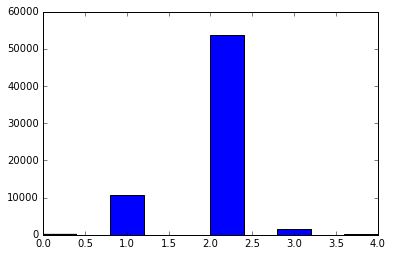

0 0.0017649188439
1 0.161301514512
2 0.811002835938
3 0.0238641163338
4 0.00206661437277


In [6]:
test_df = pd.read_table('test.tsv')

test_df["Sentiment"] = test_df["Phrase"].apply(get_sentiment_phrase)
output = test_df[['PhraseId', 'Sentiment']]

plt.hist(output.Sentiment)
plt.show()
for i in range(0, 5):
    print i, len(output[output.Sentiment == i]) / float(len(output))

output.to_csv( "ZG_rotten_tomatoes_model2.csv", index=False, quoting=3 )

The resulting csv file got a Kaggle score of 0.56008 which surprised us given the simplicity of this approach. We will next try to improve our get_sentiment_phrase function to try and get more extreme values instead of averaging only to 2. We again show the histogram and we see that our second iteration of get_sentiment_phrase is working because we see much higher counts of phrases that have sentiments 0, 1, 3, and 4.

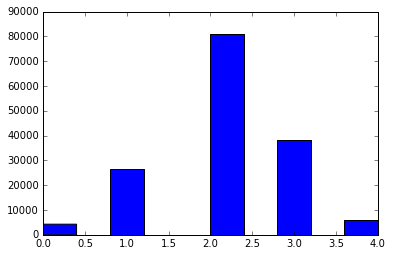

0 0.0274445726003
1 0.169883378188
2 0.519716775599
3 0.244950660003
4 0.0380046136101
Number wrong 69969
Percentage wrong 44.8346789696


In [7]:
train_df = pd.read_table('train.tsv')

def get_sentiment_phrase(phrase):
    """This function is very similar to the previous iteration except that we only append sentiments to the list for
    each phrase if they are not 2. This should force our averaging closer to the extremes."""
    phrase_sentiment = []
    for word in phrase.split():
        word_sentiment = get_sentiment_single_word(word)
        if word_sentiment > 2 or word_sentiment < 2:
            phrase_sentiment.append(word_sentiment)
    if len(phrase_sentiment):
        return int(sum(phrase_sentiment)/len(phrase_sentiment))
    else:
        return 2

train_df["calcSentiment"] = train_df["Phrase"].apply(get_sentiment_phrase2)

plt.hist(train_df.calcSentiment)
plt.show()
for i in range(0, 5):
    print i, len(train_df[train_df.calcSentiment == i]) / float(len(train_df))
    
row_ids = train_df[train_df.Sentiment != train_df.calcSentiment].index
print "Number wrong", len(row_ids)
print "Percentage wrong", (float(len(row_ids))/len(train_df)) * 100

So if we look at the percentage that this function calculated incorrectly among the training data as compared to the previous function, we see a 0.28% improvement in accuracy. We now apply the function again to the test dataset submit to Kaggle.

In [109]:
test_df = pd.read_table('test.tsv')

test_df["Sentiment"] = test_df["Phrase"].apply(get_sentiment_phrase2)
output = test_df[['PhraseId', 'Sentiment']]

output.to_csv( "ZG_rotten_tomatoes_model3.csv", index=False, quoting=3 )

The resulting csv got a Kaggle score of 0.55836 which is actually a decrease by 0.00172 from our previous function's score. There is a lot more that we could do here. We could look at the position of each sentiment within the phrase and find the most important parts of the phrase. We could take the sentiment from the middle of the phrase as the most important sentiment. We could set the sentiment of the phrase to be the value that appears most often in the list of sentiments for each phrase. Given more time, we would like to explore this further but instead, we decided to try and tackle a better method for creating the dictionary of single words.

## Using the vocab words from the tfidf vectorizer for the lookup table

The code below is identical to the one we run above except that this time, we clean the phrases before training the vecotrizer. We also store the vocab as a list which we will use to create a dictionary for each vocab word and its predicted sentiment value using the model.

In [112]:
train_df = pd.read_table('train.tsv')

def review_to_words( word ):
    """Takes as input a phrase or a word, cleans all punctuation such as commas or hyphens from it and makes all
    letters lowercase, then returns the phrase"""
    letters_only = re.sub("[^a-zA-Z]", " ", word) 
    word = letters_only.lower()
    return word

train_df.Phrase = train_df.Phrase.apply(review_to_words)

vectorizer = TfidfVectorizer()
vectorizer.fit(train_df.Phrase)
vocab = vectorizer.get_feature_names()

X = vectorizer.transform(train_df.Phrase)
y = train_df.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)
print "Accuracy", model.score(X_test, y_test)

Accuracy 0.622581058567


We now create a dictionary of the vocab words where the value for each word is the sentiment predicted using the vectorizer. We then redefine our get_sentiment_phrase function and the helper function get_sentiment_single_word to use the new dictionary and calculate our accuracy within the training dataset. In looking at the resulting histogram that is our calculated sentiment, we are again calculating a lot of sentiments as 2 which is neutral and is probably because we are again averaging each phrase and because a lot of the vocab words probably have a value of 2.

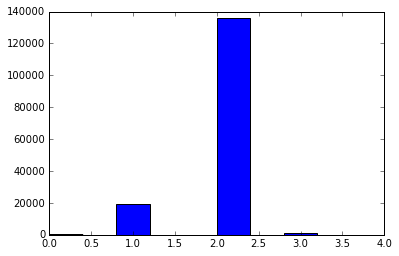

0 0.000192233756248
1 0.122529796232
2 0.869498910675
3 0.00748430090991
4 0.000294758426246
Number wrong 70344
Percentage wrong 45.0749711649


In [113]:
model.fit(X, y) #retrain the model using all of the data now before we predict on the test dataset
vocab_dict = dict(zip(vocab, model.predict(vectorizer.transform(vocab))))

train_df = pd.read_table('train.tsv')

def get_sentiment_single_word(word):
    if word in vocab_dict:
        return vocab_dict[word]
    else:
        return 2

def get_sentiment_phrase(phrase):
    phrase_sentiment = []
    for word in phrase.split():
        phrase_sentiment.append(get_sentiment_single_word(word))
    if len(phrase_sentiment):
        return int(sum(phrase_sentiment)/len(phrase_sentiment))
    else:
        return 2

train_df["calcSentiment"] = train_df["Phrase"].apply(get_sentiment_phrase)

plt.hist(train_df.calcSentiment)
plt.show()
for i in range(0, 5):
    print i, len(train_df[train_df.calcSentiment == i]) / float(len(train_df))
    
row_ids = train_df[train_df.Sentiment != train_df.calcSentiment].index
print "Number wrong", len(row_ids)
print "Percentage wrong", (float(len(row_ids))/len(train_df)) * 100

We have a slight improvement in accuracy over our original function but have lost accuracy compared to our second function. We now apply this method to the test data set to see our Kaggle score.

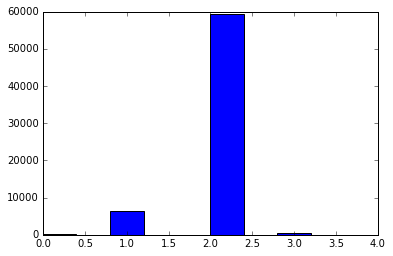

0 0.000316780305316
1 0.0960447716165
2 0.893848428166
3 0.00923188318349
4 0.000558136728414


In [96]:
test_df = pd.read_table('test.tsv')
test_df["Sentiment"] = test_df["Phrase"].apply(get_sentiment_phrase)
output = test_df[['PhraseId', 'Sentiment']]
output.to_csv("ZG_rotten_tomatoes_model4.csv", index=False, quoting=3 )

This produced a Kaggle score of 0.54805 which is still worse than using the single words from the train dataset as a lookup table. One reason for this is that all of the words that appear in the train dataset also appear in the test dataset and so for each individual word in the test data set, we have an accurate sentiment. The computations we chose to perform manually we could also use a model to predict, as we did at the beginning of this notebook, but we wanted to see how our own interpretation of sentiment was performing.